In [55]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

dataset = pd.read_csv("../data/logfile-v10.csv", delimiter=";")
dataset.head()

min_limit = 0.8
max_limit = 0.9
labels = np.unique(dataset['datacenter_name'])

### Workload placement

#### Current workload placement

Host ID '0' at datacenter 'Datacenter_1' has 9 running workloads.
Host ID '1' at datacenter 'Datacenter_1' has 7 running workloads.
Host ID '2' at datacenter 'Datacenter_1' has 8 running workloads.
Host ID '3' at datacenter 'Datacenter_1' has 8 running workloads.
Host ID '4' at datacenter 'Datacenter_1' has 9 running workloads.
Host ID '5' at datacenter 'Datacenter_1' has 8 running workloads.
Host ID '6' at datacenter 'Datacenter_1' has 8 running workloads.
Host ID '7' at datacenter 'Datacenter_1' has 8 running workloads.
Host ID '8' at datacenter 'Datacenter_1' has 8 running workloads.
Host ID '9' at datacenter 'Datacenter_1' has 7 running workloads.
Host ID '10' at datacenter 'Datacenter_1' has 8 running workloads.
Host ID '11' at datacenter 'Datacenter_1' has 7 running workloads.
Host ID '12' at datacenter 'Datacenter_1' has 8 running workloads.
Host ID '13' at datacenter 'Datacenter_1' has 7 running workloads.
Host ID '14' at datacenter 'Datacenter_1' has 6 running workloads.
Host 

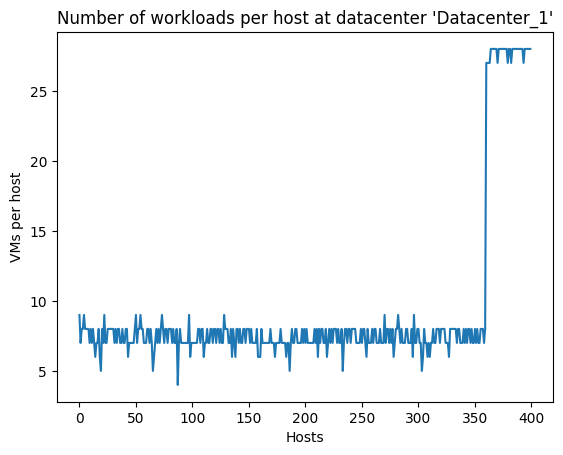

Host ID '400' at datacenter 'Datacenter_2' has 6 running workloads.
Host ID '401' at datacenter 'Datacenter_2' has 8 running workloads.
Host ID '402' at datacenter 'Datacenter_2' has 7 running workloads.
Host ID '403' at datacenter 'Datacenter_2' has 8 running workloads.
Host ID '404' at datacenter 'Datacenter_2' has 8 running workloads.
Host ID '405' at datacenter 'Datacenter_2' has 7 running workloads.
Host ID '406' at datacenter 'Datacenter_2' has 7 running workloads.
Host ID '407' at datacenter 'Datacenter_2' has 8 running workloads.
Host ID '408' at datacenter 'Datacenter_2' has 8 running workloads.
Host ID '409' at datacenter 'Datacenter_2' has 7 running workloads.
Host ID '410' at datacenter 'Datacenter_2' has 6 running workloads.
Host ID '411' at datacenter 'Datacenter_2' has 8 running workloads.
Host ID '412' at datacenter 'Datacenter_2' has 7 running workloads.
Host ID '413' at datacenter 'Datacenter_2' has 8 running workloads.
Host ID '414' at datacenter 'Datacenter_2' has 8

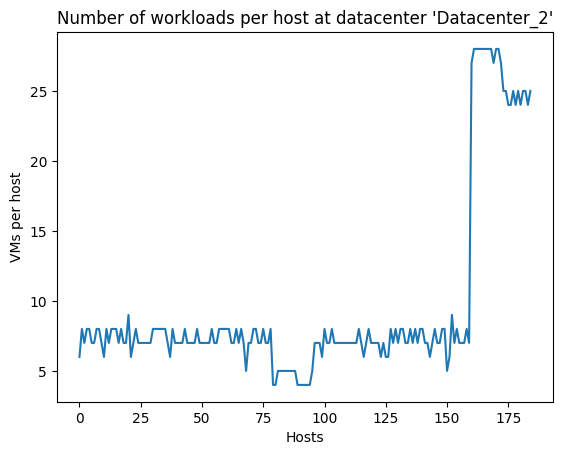

Host ID '585' at datacenter 'Datacenter_3' has 8 running workloads.
Host ID '586' at datacenter 'Datacenter_3' has 8 running workloads.
Host ID '587' at datacenter 'Datacenter_3' has 7 running workloads.
Host ID '588' at datacenter 'Datacenter_3' has 7 running workloads.
Host ID '589' at datacenter 'Datacenter_3' has 7 running workloads.
Host ID '590' at datacenter 'Datacenter_3' has 7 running workloads.
Host ID '591' at datacenter 'Datacenter_3' has 7 running workloads.
Host ID '592' at datacenter 'Datacenter_3' has 7 running workloads.
Host ID '593' at datacenter 'Datacenter_3' has 8 running workloads.
Host ID '594' at datacenter 'Datacenter_3' has 8 running workloads.
Host ID '595' at datacenter 'Datacenter_3' has 7 running workloads.
Host ID '596' at datacenter 'Datacenter_3' has 7 running workloads.
Host ID '597' at datacenter 'Datacenter_3' has 7 running workloads.
Host ID '598' at datacenter 'Datacenter_3' has 7 running workloads.
Host ID '599' at datacenter 'Datacenter_3' has 7

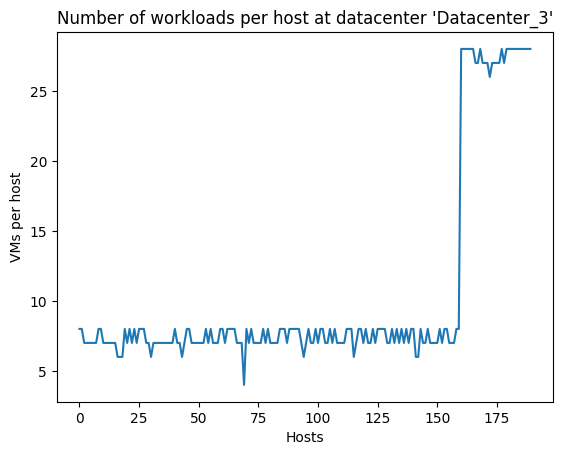

Host ID '775' at datacenter 'Datacenter_4' has 7 running workloads.
Host ID '776' at datacenter 'Datacenter_4' has 9 running workloads.
Host ID '777' at datacenter 'Datacenter_4' has 7 running workloads.
Host ID '778' at datacenter 'Datacenter_4' has 7 running workloads.
Host ID '779' at datacenter 'Datacenter_4' has 6 running workloads.
Host ID '780' at datacenter 'Datacenter_4' has 7 running workloads.
Host ID '781' at datacenter 'Datacenter_4' has 8 running workloads.
Host ID '782' at datacenter 'Datacenter_4' has 8 running workloads.
Host ID '783' at datacenter 'Datacenter_4' has 7 running workloads.
Host ID '784' at datacenter 'Datacenter_4' has 7 running workloads.
Host ID '785' at datacenter 'Datacenter_4' has 8 running workloads.
Host ID '786' at datacenter 'Datacenter_4' has 7 running workloads.
Host ID '787' at datacenter 'Datacenter_4' has 7 running workloads.
Host ID '788' at datacenter 'Datacenter_4' has 6 running workloads.
Host ID '789' at datacenter 'Datacenter_4' has 7

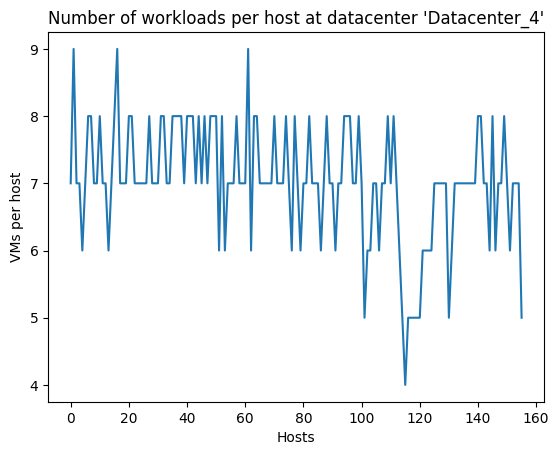

3767.0 Workloads at datacenter 'Datacenter_1'.
1772.0 Workloads at datacenter 'Datacenter_2'.
1999.0 Workloads at datacenter 'Datacenter_3'.
1096.0 Workloads at datacenter 'Datacenter_4'.
The cloud provider has 8634.0 workloads running.


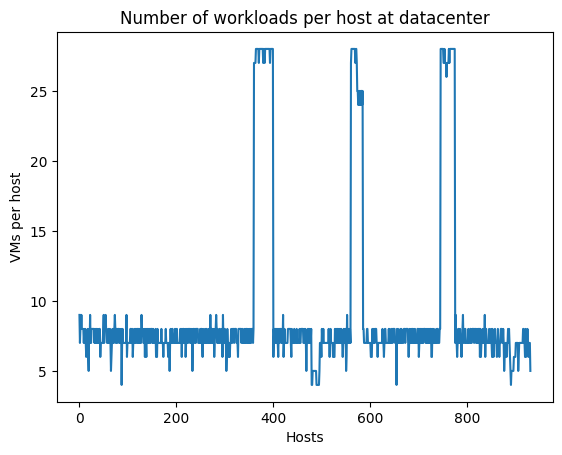

There are 119 powered down hosts.


In [56]:
labels = np.unique(dataset['datacenter_name'])
workload_per_datacenter = np.array([])
workload_per_host = np.array([])
num_powered_down_hosts = 0

max_power = 0
max_power_per_host = np.array([])
max_power_per_datacenter = np.array([])
current_power_per_datacenter = np.array([])

datacenter_over_utilized_host = np.array([])
datacenter_under_utilized_host = np.array([])

datacenter_total_pes = np.array([])
datacenter_total_mips = np.array([])
datacenter_total_ram = np.array([])
datacenter_total_bw = np.array([])
datacenter_total_storage = np.array([])

datacenter_hosts = np.array([])
datacenter_current_hosts_powered_on = np.array([])
datacenter_current_hosts_powered_off = np.array([])

datacenter_current_available_pes = np.array([])
datacenter_current_available_mips = np.array([])
datacenter_current_available_ram = np.array([])
datacenter_current_available_bw = np.array([])
datacenter_current_available_storage = np.array([])

for i in range(len(labels)):
    workload_per_datacenter_per_host = np.array([])
    
    under = 0
    over = 0
    
    max_pes = 0
    max_mips = 0
    max_ram = 0
    max_bw = 0
    max_storage = 0
    current_pes = 0
    current_mips = 0
    current_ram = 0
    current_bw = 0
    current_storage = 0
    
    hosts = 0
    hosts_power_on = 0
    hosts_power_off = 0
    
    max_power = 0
    current_power = 0
    
    for index, sample in dataset[(dataset['datacenter_name'] == labels[i]) & (dataset['time'] == 300.01)].iterrows():
        hosts += 1
        power_model = sample['power_model'].split(",")
        max_power += float(power_model[-2])
        
        current_pes += sample['available_pes']
        current_mips += sample['available_mips']
        current_ram += sample['available_ram']
        current_bw += sample['available_bw']
        current_storage += sample['available_storage']
        if sample['active'] == False:
            num_powered_down_hosts += 1
            
        else:
            hosts_power_on += 1
            # current_pes += sample['available_pes']
            # current_mips += sample['available_mips']
            # current_ram += sample['available_ram']
            # current_bw += sample['available_bw']
            # current_storage += sample['available_storage']
            
            if  ((sample['mips'] - sample['available_mips']/ sample['mips']) <= min_limit) or ((sample['ram'] - sample['available_ram']) / sample['ram'] <= min_limit) or ((sample['bw'] - sample['available_bw']) / sample['bw'] <= min_limit):
                under += 1
            elif ((sample['mips'] - sample['available_mips']/ sample['mips']) > max_limit) or ((sample['ram'] - sample['available_ram']) / sample['ram'] > max_limit) or ((sample['bw'] - sample['available_bw']) / sample['bw'] > max_limit):
                over += 1
            
            utilization = (sample['mips'] - sample['available_mips'])/sample['mips']
            if utilization % 0.1 == 0:
                current_power += utilization * 10
            else:
                utilization_floor = int(math.floor(utilization * 10))
                utilization_ceil = int(math.ceil(utilization * 10))
                power_floor = float(power_model[utilization_floor])
                power_ceil = float(power_model[utilization_ceil])
                
                diff = (power_ceil - power_floor) / 10
                current_power += power_floor + diff * (utilization - utilization_floor / 10) * 100
        
        if pd.notna(sample['vms']):
            workloads = len(sample['vms'].split(":"))-1
            print(f"Host ID '{sample['host_id']}' at datacenter '{sample['datacenter_name']}' has {workloads} running workloads.")
            workload_per_host = np.append(workload_per_host, len(sample['vms'].split(":"))-1)
            workload_per_datacenter_per_host = np.append(workload_per_datacenter_per_host, len(sample['vms'].split(":"))-1)
        
        max_pes += sample['number_of_pes']
        max_mips += sample['mips']
        max_ram += sample['ram']
        max_bw += sample['bw']
        max_storage += sample['storage']
    workload_per_datacenter = np.append(workload_per_datacenter, sum(workload_per_datacenter_per_host))
    
    datacenter_total_pes = np.append(datacenter_total_pes, max_pes)
    datacenter_total_mips = np.append(datacenter_total_mips, max_mips)
    datacenter_total_ram = np.append(datacenter_total_ram, max_ram)
    datacenter_total_bw = np.append(datacenter_total_bw, max_bw)
    datacenter_total_storage = np.append(datacenter_total_storage, max_storage)
    
    max_power_per_datacenter = np.append(max_power_per_datacenter, max_power)
    current_power_per_datacenter = np.append(current_power_per_datacenter, current_power)
    datacenter_hosts = np.append(datacenter_hosts, hosts)
    datacenter_current_hosts_powered_on = np.append(datacenter_current_hosts_powered_on, hosts_power_on)
    datacenter_current_hosts_powered_off = np.append(datacenter_current_hosts_powered_off, num_powered_down_hosts)
    
    datacenter_current_available_pes = np.append(datacenter_current_available_pes, current_pes)
    datacenter_current_available_mips = np.append(datacenter_current_available_mips, current_mips)
    datacenter_current_available_ram = np.append(datacenter_current_available_ram, current_ram)
    datacenter_current_available_bw = np.append(datacenter_current_available_bw, current_bw)
    datacenter_current_available_storage = np.append(datacenter_current_available_storage, current_storage)
    
    datacenter_over_utilized_host = np.append(datacenter_over_utilized_host, over)
    datacenter_under_utilized_host = np.append(datacenter_under_utilized_host, under)
    
    plt.plot(np.arange(len(workload_per_datacenter_per_host)), workload_per_datacenter_per_host, label="Workloads per host")
    plt.xlabel("Hosts")
    plt.ylabel("VMs per host")
    plt.title(f"Number of workloads per host at datacenter '{labels[i]}'")
    #plt.legend()
    plt.show()

for i in range(len(labels)):
    print(f"{workload_per_datacenter[i]} Workloads at datacenter '{labels[i]}'.")
print(f"The cloud provider has {sum(workload_per_datacenter)} workloads running.")

plt.plot(np.arange(len(workload_per_host)), workload_per_host, label="Workloads per host")
plt.xlabel("Hosts")
plt.ylabel("VMs per host")
plt.title(f"Number of workloads per host at datacenter")
#plt.legend()
plt.show()

print(f"There are {num_powered_down_hosts} powered down hosts.")

#### Simple resource aware workload placement

In [57]:

vms = []
hosts = []
for index, sample in dataset[dataset['time'] == 300.01].iterrows():
    hosts.append({
        "id": index,
        "datacenter": sample['datacenter_name'],
        "active": sample['active'],
        "power_model": sample['power_model'].split(","),
        "pes": int(sample['number_of_pes']),
        "mips": float(sample['mips']),
        "used_mips": (float(sample['mips']) - float(sample['available_mips'])),
        "ram": float(sample['ram']),
        "used_ram": (float(sample['ram']) - float(sample['available_ram'])),
        "bw": float(sample['bw']),
        "used_bw": (float(sample['bw']) - float(sample['available_bw'])),
    })
    if pd.notna(sample['vms']):
        for index, vm in enumerate(sample['vms'].split(":")):
            vm_allocated_resources = vm.split(",")
            if len(vm_allocated_resources) != 4:
                continue
            # print("-----------")
            # print(vm_allocated_resources)
            # print(vm_allocated_resources[2])
            # print("-----------")
            vms.append({
                "id": index,
                "pes": int(vm_allocated_resources[0]),
                "mips": float(vm_allocated_resources[1]),
                "ram": float(vm_allocated_resources[2]),
                "bw": float(vm_allocated_resources[3])
            })

vms_copy = vms.copy()
new_workloads_placement = []
for index_host, host in enumerate(hosts):
    used_mips = 0
    used_ram = 0
    used_bw = 0
    workloads_per_host = []
    
    for index_vm, vm in enumerate(vms_copy):
        if ((vm['mips'] + used_mips) <= host['mips']) and ((vm['ram'] + used_ram) <= host['ram']) and ((vm['bw'] + used_bw) <= host['bw']):
            used_mips += vm['pes']
            used_mips += vm['mips']
            used_ram += vm['ram']
            used_bw += vm['bw']
            # used_bw += vm['storage']
            workloads_per_host.append(vm)
    
    new_workloads_placement.append(workloads_per_host)
    for index_vm, vm in enumerate(workloads_per_host):
        run = True
        index = 0
        while run:
            if vm['id'] == vms_copy[index]['id']:
                del vms_copy[index]
                run = False
            index += 1
    

Host ID '0' has 9 workloads running, utilizing (3612.6341234133333/6000.0) MIPS, (3983.0/4000.0) RAM, and (162.0/10000.0) Bandwidth,
 as supposed to (3612.6341234133333/6000.0) MIPS, (3983.0/4000.0) RAM, and (162.0/10000.0) Bandwidth, 
consuming 0.14712634123413335 Kilo Joules (kJ) per hour,
 with the previous workload placement consuming 0.14712634123413335 Kilo Joules (kJ) per hour.

Host ID '1' has 7 workloads running, utilizing (2723.130257173333/6000.0) MIPS, (3944.0/4000.0) RAM, and (93.0/10000.0) Bandwidth,
 as supposed to (2723.130257173333/6000.0) MIPS, (3944.0/4000.0) RAM, and (93.0/10000.0) Bandwidth, 
consuming 0.13423130257173332 Kilo Joules (kJ) per hour,
 with the previous workload placement consuming 0.13423130257173332 Kilo Joules (kJ) per hour.

Host ID '2' has 8 workloads running, utilizing (2879.18356704/6000.0) MIPS, (3921.0/4000.0) RAM, and (71.0/10000.0) Bandwidth,
 as supposed to (2879.18356704/6000.0) MIPS, (3921.0/4000.0) RAM, and (71.0/10000.0) Bandwidth, 
co

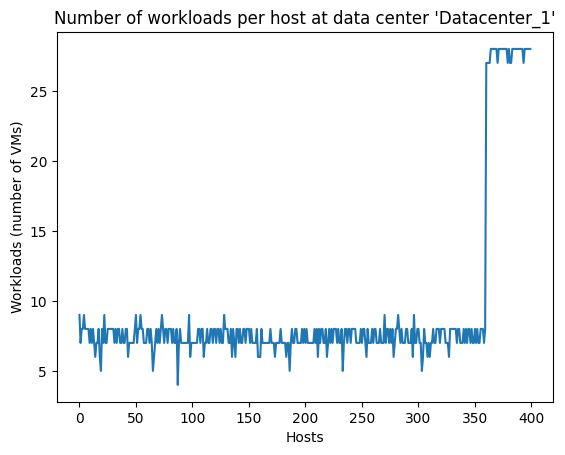

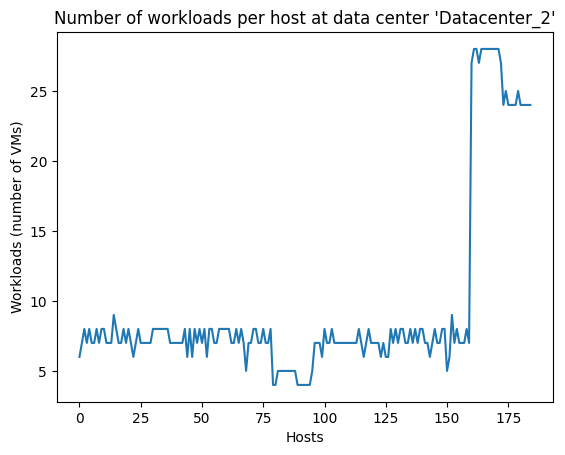

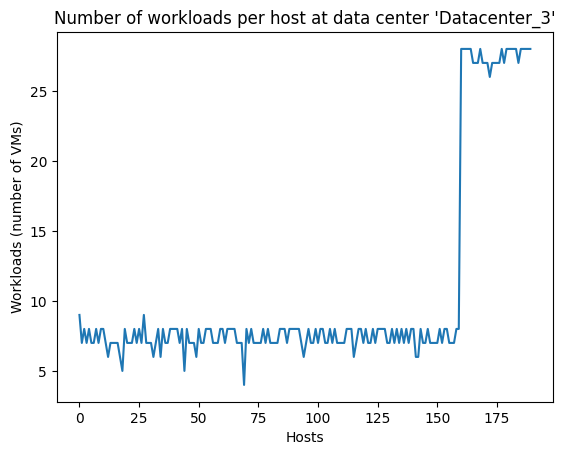

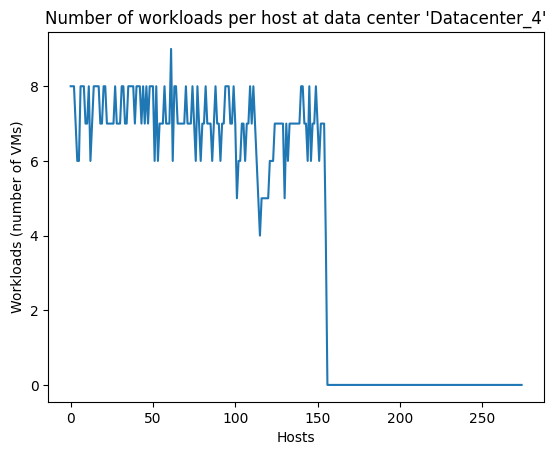

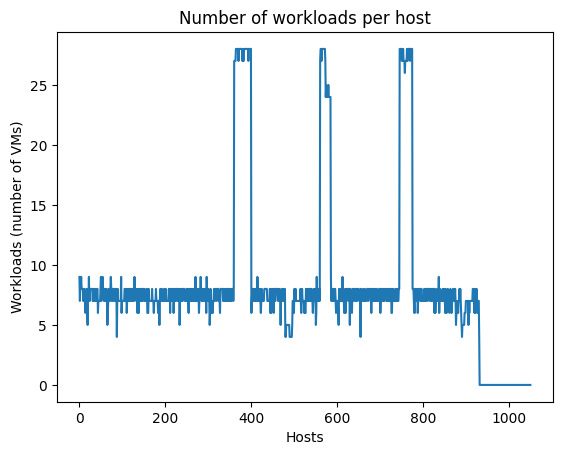

In [58]:
# Calculating the resource utilzation and the energy consumption.
new_power_per_host = np.array([])
current_power_per_host = np.array([])
new_workloads_placement_per_datacenter_per_host = {}

datacenter_resource_aware_placement_workloads = np.zeros(len(labels))
datacenter_resource_aware_placement_power = np.zeros(len(labels))

datacenter_resource_aware_placement_over_utilized_host = np.zeros(len(labels))
datacenter_resource_aware_placement_under_utilized_host = np.zeros(len(labels))

datacenter_resource_aware_placement_used_pes = np.zeros(len(labels))
datacenter_resource_aware_placement_used_mips = np.zeros(len(labels))
datacenter_resource_aware_placement_used_ram = np.zeros(len(labels))
datacenter_resource_aware_placement_used_bw = np.zeros(len(labels))
# datacenter_resource_aware_placement_available_storage = np.zeros(len(labels))

datacenter_resource_aware_placement_hosts_powered_off = np.zeros(len(labels))
datacenter_resource_aware_placement_hosts_powered_on = np.zeros(len(labels))




new_workloads_placement_per_host = np.array([])
for index_host, host in enumerate(new_workloads_placement):
    used_pes = 0
    used_mips = 0
    used_ram = 0
    used_bw = 0
    # used_storage = 0
    vms = len(host)
    
    new_workloads_placement_per_host = np.append(new_workloads_placement_per_host, vms)
    # print(new_workloads_placement_per_datacenter_per_host.keys() in )
    # print(hosts[index_host]['datacenter'])
    # print(new_workloads_placement_per_datacenter_per_host['sd'])
    # print(new_workloads_placement_per_datacenter_per_host[hosts[index_host]['datacenter']])
    if hosts[index_host]['datacenter'] not in new_workloads_placement_per_datacenter_per_host.keys():
        # print(new_workloads_placement_per_datacenter_per_host[hosts[index_host]['datacenter']])
        new_workloads_placement_per_datacenter_per_host[hosts[index_host]['datacenter']] = np.array([])
    new_workloads_placement_per_datacenter_per_host[hosts[index_host]['datacenter']] = np.append(new_workloads_placement_per_datacenter_per_host[hosts[index_host]['datacenter']], vms)
    
    new_host_power = 0
    current_host_power = 0
    for index_vm, vm in enumerate(host):
        used_pes += int(vm['pes'])
        used_mips += vm['mips']
        used_ram += vm['ram']
        used_bw += vm['bw']
        # used_storage += vm['storage']
    if used_pes > int(hosts[index_host]['pes']):
        used_pes = hosts[index_host]['pes']
            
    datacenter_index = np.where(hosts[index_host]['datacenter'] == labels)[0][0]
    # print("Used PEs:", used_pes)
    # print("Used MIPS:", used_mips)
    # print("Used RAM:", used_ram)
    # print("Used BW:", used_bw)
    # Getting the power consumption and resource utilization of the new workload placement
    datacenter_resource_aware_placement_workloads[datacenter_index] += vms
    if (used_mips == 0) and (used_ram == 0) and (used_bw == 0):
        datacenter_resource_aware_placement_hosts_powered_off[datacenter_index] += 1
        
        datacenter_resource_aware_placement_used_pes[datacenter_index] += hosts[index_host]['pes']
        datacenter_resource_aware_placement_used_mips[datacenter_index] += hosts[index_host]['mips']
        datacenter_resource_aware_placement_used_ram[datacenter_index] += hosts[index_host]['ram']
        datacenter_resource_aware_placement_used_bw[datacenter_index] += hosts[index_host]['bw']
    else:
        datacenter_resource_aware_placement_hosts_powered_on[datacenter_index] += 1
        
        datacenter_resource_aware_placement_used_pes[datacenter_index] += used_pes
        datacenter_resource_aware_placement_used_mips[datacenter_index] += used_mips
        datacenter_resource_aware_placement_used_ram[datacenter_index] += used_ram
        datacenter_resource_aware_placement_used_bw[datacenter_index] += used_bw
        # datacenter_resource_aware_placement_available_storage[datacenter_index] = used_storage

        utilization = used_mips/hosts[index_host]['mips']
        if utilization % 0.1 == 0:
            new_host_power += utilization * 10
            datacenter_resource_aware_placement_power[datacenter_index] += new_host_power
        else:
            utilization_floor = int(math.floor(utilization * 10))
            utilization_ceil = int(math.ceil(utilization * 10))
            power_floor = float(hosts[index_host]['power_model'][utilization_floor])
            power_ceil = float(hosts[index_host]['power_model'][utilization_ceil])
            
            diff = (power_ceil - power_floor) / 10
            new_host_power = power_floor + diff * (utilization - utilization_floor / 10) * 100
            new_power_per_host = np.append(new_power_per_host, new_host_power)
            datacenter_resource_aware_placement_power[datacenter_index] += new_host_power
        
        if used_mips/hosts[index_host]['mips'] <= min_limit or used_ram/hosts[index_host]['ram'] <= min_limit or used_bw/hosts[index_host]['bw'] <= min_limit:
            datacenter_resource_aware_placement_under_utilized_host[datacenter_index]  += 1
        elif used_mips/hosts[index_host]['mips'] > max_limit or used_ram/hosts[index_host]['ram'] > max_limit or used_bw/hosts[index_host]['bw'] > max_limit :
            datacenter_resource_aware_placement_over_utilized_host[datacenter_index]  += 1
    
    # Getting the power consumption and resource utilization of the current workload placement
    if hosts[index_host]['active'] == False:
        pass
    else:
        utilization = hosts[index_host]['used_mips']/hosts[index_host]['mips']
        if utilization % 0.1 == 0:
            current_host_power = utilization * 10
        
        utilization_floor = int(math.floor(utilization * 10))
        utilization_ceil = int(math.ceil(utilization * 10))
        power_floor = float(hosts[index_host]['power_model'][utilization_floor])
        power_ceil = float(hosts[index_host]['power_model'][utilization_ceil])
        
        diff = (power_ceil - power_floor) / 10
        current_host_power = power_floor + diff * (utilization - utilization_floor / 10) * 100
        current_power_per_host = np.append(current_power_per_host, current_host_power)
    
    print(f"Host ID '{index_host}' has {vms} workloads running, utilizing ({used_mips}/{hosts[index_host]['mips']}) MIPS, ({used_ram}/{hosts[index_host]['ram']}) RAM, and ({used_bw}/{hosts[index_host]['bw']}) Bandwidth,\n as supposed to ({hosts[index_host]['used_mips']}/{hosts[index_host]['mips']}) MIPS, ({hosts[index_host]['used_ram']}/{hosts[index_host]['ram']}) RAM, and ({hosts[index_host]['used_bw']}/{hosts[index_host]['bw']}) Bandwidth, \nconsuming {(new_host_power * 1)/1000} Kilo Joules (kJ) per hour,\n with the previous workload placement consuming {(current_host_power * 1)/1000} Kilo Joules (kJ) per hour.\n")
print(f"Cloud provider's power consumption would then be with the new placements be {(sum(new_power_per_host) * 1)/1000} Kilo Joules per hour,\n as supposed to the previous workload placements consuming {(sum(current_power_per_host) * 1)/1000} Kilo Joules per hour.")


for key in new_workloads_placement_per_datacenter_per_host.keys():
    print()
    plt.plot(np.arange(len(new_workloads_placement_per_datacenter_per_host[key])), new_workloads_placement_per_datacenter_per_host[key], label="Workloads per host")
    plt.xlabel("Hosts")
    plt.ylabel("Workloads (number of VMs)")
    plt.title(f"Number of workloads per host at data center '{key}'")
    #plt.legend()
    plt.show()

plt.plot(np.arange(len(new_workloads_placement_per_host)), new_workloads_placement_per_host, label="Workloads per host")
plt.xlabel("Hosts")
plt.ylabel("Workloads (number of VMs)")
plt.title("Number of workloads per host")
#plt.legend()
plt.show()

In [59]:

# datacenters = []
# vms = []
# hosts = []
# for label in labels:
#     datacenter_vms = []
#     datacenter_hosts = []
    
#     for index, sample in dataset[(dataset['datacenter_name'] == label) & (dataset['time'] == 300.01)].iterrows():
#         datacenter_hosts.append({
#             "id": index,
#             "datacenter": sample['datacenter_name'],
#             "active": sample['active'],
#             "power_model": sample['power_model'].split(","),
#             "pes": int(sample['number_of_pes']),
#             "mips": float(sample['mips']),
#             "used_mips": (float(sample['mips']) - float(sample['available_mips'])),
#             "ram": float(sample['ram']),
#             "used_ram": (float(sample['ram']) - float(sample['available_ram'])),
#             "bw": float(sample['bw']),
#             "used_bw": (float(sample['bw']) - float(sample['available_bw'])),
#         })
#         if pd.notna(sample['vms']):
#             for index, vm in enumerate(sample['vms'].split(":")):
#                 vm_allocated_resources = vm.split(",")
#                 if len(vm_allocated_resources) != 4:
#                     continue
#                 datacenter_vms.append({
#                     "id": index,
#                     "pes": int(vm_allocated_resources[0]),
#                     "mips": float(vm_allocated_resources[1]),
#                     "ram": float(vm_allocated_resources[2]),
#                     "bw": float(vm_allocated_resources[3])
#                 })
#     datacenter = {
#         "hosts": datacenter_hosts,
#         "vms": datacenter_vms,
#         "new_workload_placement": [],
#         "new_workload_placement_per_host": []
#     }

# for datacenter in datacenters:
#     vms_copy = datacenter['vms'].copy()
#     new_workloads_placement = []
#     for index_host, host in enumerate(datacenter['hosts']):
#         used_mips = 0
#         used_ram = 0
#         used_bw = 0
#         workloads_per_host = []
        
#         for index_vm, vm in enumerate(vms_copy):
#             if ((vm['mips'] + used_mips) <= host['mips']) and ((vm['ram'] + used_ram) <= host['ram']) and ((vm['bw'] + used_bw) <= host['bw']):
#                 used_mips += vm['mips']
#                 used_ram += vm['ram']
#                 used_bw += vm['bw']
#                 workloads_per_host.append(vm)
        
#         new_workloads_placement.append(workloads_per_host)
#         for index_vm, vm in enumerate(workloads_per_host):
#             run = True
#             index = 0
#             while run:
#                 if vm['id'] == vms_copy[index]['id']:
#                     del vms_copy[index]
#                     run = False
#                 index += 1
#     datacenter['new_workloads_placement'] = new_workloads_placement

In [60]:
# # Calculating the resource utilzation and the energy consumption.
# new_power_per_host = np.array([])
# new_power_per_datacenter = np.array([])
# current_power_per_host = np.array([])
# new_workloads_placement_per_datacenter_per_host = {}

# for index, label in enumerate(labels):
#     new_workloads_placement_per_host = np.array([])
#     for index_host, host in enumerate(datacenters[index]['new_workloads_placement']):
#         used_mips = 0
#         used_ram = 0
#         used_bw = 0
#         vms = len(host)
        
#         new_workloads_placement_per_host = np.append(new_workloads_placement_per_host, vms)
#         # print(new_workloads_placement_per_datacenter_per_host.keys() in )
#         # print(hosts[index_host]['datacenter'])
#         # print(new_workloads_placement_per_datacenter_per_host['sd'])
#         # print(new_workloads_placement_per_datacenter_per_host[hosts[index_host]['datacenter']])
#         if hosts[index_host]['datacenter'] not in new_workloads_placement_per_datacenter_per_host.keys():
#             # print(new_workloads_placement_per_datacenter_per_host[hosts[index_host]['datacenter']])
#             new_workloads_placement_per_datacenter_per_host[hosts[index_host]['datacenter']] = np.array([])
#         new_workloads_placement_per_datacenter_per_host[hosts[index_host]['datacenter']] = np.append(new_workloads_placement_per_datacenter_per_host[hosts[index_host]['datacenter']], vms)
        
#         new_host_power = 0
#         current_host_power = 0
#         for index_vm, vm in enumerate(host):
#             used_mips += vm['mips']
#             used_ram += vm['ram']
#             used_bw += vm['bw']
                
#         # Getting the power consumption and resource utilization of the new workload placement
#         if (used_mips == 0) and (used_ram == 0) and (used_bw == 0):
#             pass
#         else:
#             utilization = used_mips/hosts[index_host]['mips']
#             if utilization % 0.1 == 0:
#                 new_host_power += utilization * 10
#             else:
#                 utilization_floor = int(math.floor(utilization * 10))
#                 utilization_ceil = int(math.ceil(utilization * 10))
#                 power_floor = float(hosts[index_host]['power_model'][utilization_floor])
#                 power_ceil = float(hosts[index_host]['power_model'][utilization_ceil])
                
#                 diff = (power_ceil - power_floor) / 10
#                 new_host_power = power_floor + diff * (utilization - utilization_floor / 10) * 100
#                 new_power_per_host = np.append(new_power_per_host, new_host_power)
        
#         # Getting the power consumption and resource utilization of the current workload placement
#         if hosts[index_host]['active'] == False:
#             pass
#         else:
#             utilization = hosts[index_host]['used_mips']/hosts[index_host]['mips']
#             if utilization % 0.1 == 0:
#                 current_host_power = utilization * 10
            
#             utilization_floor = int(math.floor(utilization * 10))
#             utilization_ceil = int(math.ceil(utilization * 10))
#             power_floor = float(hosts[index_host]['power_model'][utilization_floor])
#             power_ceil = float(hosts[index_host]['power_model'][utilization_ceil])
            
#             diff = (power_ceil - power_floor) / 10
#             current_host_power = power_floor + diff * (utilization - utilization_floor / 10) * 100
#             current_power_per_host = np.append(current_power_per_host, current_host_power)
#         print(f"Host ID '{index_host}' has {vms} workloads running, utilizing ({used_mips}/{hosts[index_host]['mips']}) MIPS, ({used_ram}/{hosts[index_host]['ram']}) RAM, and ({used_bw}/{hosts[index_host]['bw']}) Bandwidth,\n as supposed to ({hosts[index_host]['used_mips']}/{hosts[index_host]['mips']}) MIPS, ({hosts[index_host]['used_ram']}/{hosts[index_host]['ram']}) RAM, and ({hosts[index_host]['used_bw']}/{hosts[index_host]['bw']}) Bandwidth, \nconsuming {(new_host_power * 1)/1000} Kilo Joules (kJ) per hour,\n with the previous workload placement consuming {(current_host_power * 1)/1000} Kilo Joules (kJ) per hour.\n")
#     # print(f"Cloud provider's power consumption would then be with the new placements be {(sum(new_power_per_host) * 1)/1000} Kilo Joules per hour,\n as supposed to the previous workload placements consuming {(sum(current_power_per_host) * 1)/1000} Kilo Joules per hour.")
# print(f"Cloud provider's power consumption would then be with the new placements be {(sum(new_power_per_host) * 1)/1000} Kilo Joules per hour,\n as supposed to the previous workload placements consuming {(sum(current_power_per_host) * 1)/1000} Kilo Joules per hour.")


# # for key in new_workloads_placement_per_datacenter_per_host.keys():
# #     print()
# #     plt.plot(np.arange(len(new_workloads_placement_per_datacenter_per_host[key])), new_workloads_placement_per_datacenter_per_host[key], label="Workloads per host")
# #     plt.xlabel("Hosts")
# #     plt.ylabel("Workloads (number of VMs)")
# #     plt.title(f"Number of workloads per host at data center '{key}'")
# #     #plt.legend()
# #     plt.show()

# # plt.plot(np.arange(len(new_workloads_placement_per_host)), new_workloads_placement_per_host, label="Workloads per host")
# # plt.xlabel("Hosts")
# # plt.ylabel("Workloads (number of VMs)")
# # plt.title("Number of workloads per host")
# # #plt.legend()
# # plt.show()

#### Optimal resource aware workload placement 

In [61]:
# import itertools
# def test_1(host, vms, num):
#     results = []
#     # combinations = itertools.permutations(vms, num)
#     for combo in itertools.permutations(vms, num):
#         print("1", end="")
#         vms_utilization = {
#             "mips": 0,
#             "ram": 0,
#             "bw": 0,
#             "vms": []
#         }
#         for vm in combo:
#             vms_utilization['mips'] += vm['mips']
#             vms_utilization['ram'] += vm['ram']
#             vms_utilization['bw'] += vm['bw']
#             vms_utilization['vms'].append(vm)
#         results.append(vms_utilization)
#     return results

# tmp_vms = vms.copy()
# new_workload_list = []
# for host in hosts:
#     print("------- Host -------")
#     run = True
#     index = 1
#     prev_results = []
#     results = []
#     while run:
#         print("------- run -------")
#         num_under = 0
#         num_over = 0 
#         results = test_1(host, tmp_vms, index)
        
#         for result in results:
#             mips_utilization = (result['mips']/host['mips'])*100
#             ram_utilization = (result['ram']/host['ram'])*100
#             bw_utilization = (result['bw']/host['bw'])*100
            
#             if run == True and ((mips_utilization > 80 and mips_utilization < 90) and (ram_utilization > 80 and ram_utilization < 90) and (bw_utilization > 80 and bw_utilization < 90)): # optimal utilization (avoiding under and over utilization)
#                 print("------- optimal -------")
#                 new_workload_list.append(results['vms'])
#                 run = False
#             elif run == True and (mips_utilization < 80 and ram_utilization < 80 and bw_utilization < 80): # underutilized
#                 num_under += 1
#             elif run == True and (mips_utilization > 90 and ram_utilization > 90 and bw_utilization > 90): # overutilized
#                 num_over += 1
#         print("------- run 2 -------")
#         if run == True and num_under > num_over:
#             print("------- under -------")
#             index += 1
#             prev_results = results
#         elif run == True and num_over > num_under:
#             # picking the best out the previous results
#             print("------- over -------")
#             best = {}
#             utilization = {
#                 "mips": 0,
#                 "ram": 0,
#                 "bw": 0
#             }
#             for result in prev_results: # Could improve 
#                 mips_utilization = (result['mips']/host['mips'])*100
#                 ram_utilization = (result['ram']/host['ram'])*100
#                 bw_utilization = (result['bw']/host['bw'])*100
                
#                 if mips_utilization > utilization['mips'] and ram_utilization > utilization['ram'] and bw_utilization > utilization['bw']:
#                     best = result
#                     utilization['mips'] = mips_utilization
#                     utilization['ram'] = ram_utilization
#                     utilization['bw'] = bw_utilization
            
#             new_workload_list.append(best)
#             run = False
            
#     for vm in new_workload_list[-1]['vms']:
#         del tmp_vms[vm['id']]

In [62]:
# for index, host in enumerate(new_workload_list):
#     print(f"Host '{index}' has {len(host['vms'])} workloads")

### Re-organization of workload placement

Rebalancing over utilized and under utilized physical host with the goal if better utilizing hosts.

In [63]:
labels = np.unique(dataset['datacenter_name'])
vms_reorganized = []
hosts_reorganized = []

vms_to_reallocate = np.array([])
num_powered_down_hosts_before = 0
over_utilized_hosts_before = 0
under_utilized_hosts_before = 0
optimal_hosts_before = 0

def find_vm_index(vms_temp, vm_id):
    index_of_vm = -1
    for index, vm_temp in enumerate(vms_temp):
        if vm_temp['id'] == vm_id:
            index_of_vm = index
    return index_of_vm

def find_vm_combo(mips, ram, bw, vms, min_limit, max_limit):
    # optimal_vm_combination = {
    #     "vms": [],
    #     "unused_vms": [],
    #     "mips": 0,
    #     "ram": 0,
    #     "bw": 0,
    #     "points": 0
    # }
    # for vms_num in range(len(vms)):
    #     if (len(vms) == 27):
    #         print(f"progress ({vms_num}/{len(vms)})")
    #     for combo in combinations(vms, vms_num):
    #         if optimal_vm_combination['vms'] == []:
    #             for vm in combo:
    #                 optimal_vm_combination['vms'].append(vm)
    #                 optimal_vm_combination['mips'] += vm['mips']
    #                 optimal_vm_combination['ram'] += vm['ram']
    #                 optimal_vm_combination['bw'] += vm['bw']
    #             optimal_vm_combination['points'] = ((optimal_vm_combination['mips'] / mips)*10) + ((optimal_vm_combination['ram'] / ram)*10) + ((optimal_vm_combination['bw'] / bw)*10)
    #         else:
    #             temp_optimal_vm_combination = {
    #                 "vms": [],
    #                 "unused_vms": [],
    #                 "mips": 0,
    #                 "ram": 0,
    #                 "bw": 0,
    #                 "points": 0
    #             }
    #             for vm in combo:
    #                 temp_optimal_vm_combination['vms'].append(vm)
    #                 temp_optimal_vm_combination['mips'] += vm['mips']
    #                 temp_optimal_vm_combination['ram'] += vm['ram']
    #                 temp_optimal_vm_combination['bw'] += vm['bw']
    #             temp_optimal_vm_combination['points'] = ((temp_optimal_vm_combination['mips'] / mips)*10) + ((temp_optimal_vm_combination['ram'] / ram)*10) + ((temp_optimal_vm_combination['bw'] / bw)*10)
                    
    #             if temp_optimal_vm_combination['points'] > optimal_vm_combination['points'] and ((temp_optimal_vm_combination['mips'] / mips) <= 0.9 and (temp_optimal_vm_combination['ram'] / ram) <= 0.9 and (temp_optimal_vm_combination['bw'] / bw) <= 0.9):
    #                 optimal_vm_combination = temp_optimal_vm_combination
    #  temp_optimal_vm_combination = {
    #     "vms": [],
    #     "unused_vms": [],
    #     "mips": 0,
    #     "ram": 0,
    #     "bw": 0,
    #     "points": 0
    # }
    # for vm in vms:
    #     found = False
    #     for vm_used in optimal_vm_combination['vms']:
    #         if vm_used['id'] == vm['id']:
    #             found = True
        
    #     if found == False:
    #         optimal_vm_combination['unused_vms'].append(vm)
    
    # return optimal_vm_combination
    
    selected_vms = []
    unused_vms = []
    used_mips = 0
    used_ram = 0
    used_bw = 0
    points = 0
    for vm in vms:
        if ((used_mips + vm['mips']) / mips) < max_limit and ((used_ram + vm['ram']) / ram) < max_limit and ((used_bw + vm['bw']) / bw) < max_limit:
            temp_points = ((used_mips + vm['mips']) / mips) * 10 + ((used_ram + vm['ram']) / ram) * 10 + ((used_bw + vm['bw']) / bw) * 10
            if temp_points > points:
                points = temp_points
                selected_vms.append(vm)
                used_mips += vm['mips']
                used_ram += vm['ram']
                used_bw += vm['bw']
        # temp_optimal_vm_combination['points'] = ((temp_optimal_vm_combination['mips'] / mips)*10) + ((temp_optimal_vm_combination['ram'] / ram)*10) + ((temp_optimal_vm_combination['bw'] / bw)*10)
    for vm in vms:
        found = False
        for vm_used in selected_vms:
            if vm_used['id'] == vm['id']:
                found = True
        
        if found == False:
            unused_vms.append(vm)
    
    return {
        "vms": selected_vms,
        "unused_vms": unused_vms,
        "mips": used_mips,
        "ram": used_ram,
        "bw": used_bw,
        "points": points
    }

for i in range(len(labels)):
    for index, sample in dataset[(dataset['datacenter_name'] == labels[i]) & (dataset['time'] == 300.01)].iterrows():
        
        # print(f"Host {sample['host_id']} and their vms generated")
        vms_temp = []
        if pd.notna(sample['vms']):
            for index_vm, vm in enumerate(sample['vms'].split(":")):
                    if vm != "":
                        vm_allocated_resources = vm.split(",")
                        vms_temp.append({
                            "id": index_vm,
                            "pes": int(vm_allocated_resources[0]),
                            "mips": float(vm_allocated_resources[1]),
                            "ram": float(vm_allocated_resources[2]),
                            "bw": float(vm_allocated_resources[3])
                        })
        # check if host is over utilized
        mips_utilization = (sample['mips'] - sample['available_mips']) / sample['mips']
        ram_utilization = (sample['ram'] - sample['available_ram']) / sample['ram']
        bw_utilization = (sample['bw'] - sample['available_bw']) / sample['bw']
        
        if (mips_utilization >= 0.8 and mips_utilization <= 0.9) and (ram_utilization >= 0.8 and ram_utilization <= 0.9) and (bw_utilization >= 0.8 and bw_utilization <= 0.9):
            optimal_hosts_before += 1
        elif mips_utilization > 0.9 or ram_utilization > 0.9 or bw_utilization > 0.9:
            over_utilized_hosts_before += 1
            if pd.notna(sample['vms']):
                #workloads = len(sample['vms'].split(":"))-1
                
                # temp_available_mips = sample['available_mips']
                # temp_available_ram = sample['available_ram']
                # temp_available_bw = sample['available_bw']
        
                # print("------------")
                # print((sample['mips'] - sample['available_mips']) / sample['mips'])
                # print((sample['ram'] - sample['available_ram']) / sample['ram'])
                # print((sample['bw'] - sample['available_bw']) / sample['bw'])
                # print("---")
                vm_combo = find_vm_combo(sample['mips'], sample['ram'], sample['bw'], vms_temp.copy(), min_limit, max_limit)
                # print("------------")
                # print(len(vm_combo['vms']))
                # print(len(vm_combo['unused_vms']))
                # print(vm_combo['mips'] / sample['mips'])
                # print(vm_combo['ram'] / sample['ram'])
                # print(vm_combo['bw'] / sample['bw'])
                # print(vm_combo['points'])
                # print("------------")
                # print((vm_combo['mips'] + vm_combo['unused_vms'][0]['mips']) / sample['mips'])
                # print((vm_combo['ram'] + vm_combo['unused_vms'][0]['ram'])/ sample['ram'])
                # print((vm_combo['bw'] + vm_combo['unused_vms'][0]['bw']) / sample['bw'])
                
                vms_temp = vm_combo['vms']
                for vm in vm_combo['unused_vms']:
                    vms_to_reallocate = np.append(vms_to_reallocate, vm)
                
                sample['available_mips'] = sample['mips'] - vm_combo['mips']
                sample['available_ram'] = sample['ram'] - vm_combo['ram']
                sample['available_bw'] = sample['bw'] - vm_combo['bw']
                
                # non_optimal_vms = []
                # for index_vm, vm in enumerate(sample['vms'].split(":")): # pes, mips, ram, bw
                #     if vm != "":
                #         vm_allocated_resources = vm.split(",")
                #         mips_utilization = ((sample['mips'] - sample['available_mips']) - float(vm_allocated_resources[1])) / sample['mips']
                #         ram_utilization = ((sample['ram'] - sample['available_ram']) - float(vm_allocated_resources[2])) / sample['ram']
                #         bw_utilization = ((sample['bw'] - sample['available_bw']) - float(vm_allocated_resources[3])) / sample['bw']
                        
                #         mips_optimal = (mips_utilization >= 0.8 and mips_utilization <= 0.9) 
                #         ram_optimal = (ram_utilization >= 0.8 and ram_utilization <= 0.9)
                #         bw_optimal = (bw_utilization >= 0.8 and bw_utilization <= 0.9)
                        

                #         if mips_optimal and ram_optimal and bw_optimal:
                            
                #             temp_available_mips += float(vm_allocated_resources[1])
                #             temp_available_ram += float(vm_allocated_resources[2])
                #             temp_available_bw += float(vm_allocated_resources[3])
                            
                #             index_of_vm = find_vm_index(vms_temp, vm_allocated_resources[0])
                #             vms_to_reallocate = np.append(vms_to_reallocate, index_of_vm)
                #             vms_temp = np.delete(vms_temp, index_of_vm)
                #         elif bw_utilization > 0.9 or ram_utilization > 0.9 or bw_utilization > 0.9:
                            
                # sample['available_mips'] = temp_available_mips
                # sample['available_ram'] = temp_available_ram
                # sample['available_bw'] = temp_available_bw
                
                # print("---")
                # print((sample['mips'] - sample['available_mips']) / sample['mips'])
                # print((sample['ram'] - sample['available_ram']) / sample['ram'])
                # print((sample['bw'] - sample['available_bw']) / sample['bw'])
                # print("------------")
        elif mips_utilization == 0 and ram_utilization == 0 and bw_utilization == 0:
            num_powered_down_hosts_before += 1
        elif mips_utilization < 0.8 or ram_utilization < 0.8 or bw_utilization < 0.8:
            under_utilized_hosts_before += 1
        
        
        
        hosts_reorganized.append({
            "id": sample['host_id'],
            "datacenter": sample['datacenter_name'],
            "active": bool(sample['active']),
            "power_model": sample['power_model'].split(","),
            "pes": int(sample['number_of_pes']),
            "used_pes": int(sample['number_of_pes']) - int(sample['available_pes']),
            "mips": float(sample['mips']),
            "used_mips": (float(sample['mips']) - float(sample['available_mips'])),
            "ram": float(sample['ram']),
            "used_ram": (float(sample['ram']) - float(sample['available_ram'])),
            "bw": float(sample['bw']),
            "used_bw": (float(sample['bw']) - float(sample['available_bw'])),
            "vms": vms_temp
        })
        
print(f"There were {num_powered_down_hosts_before} powered down hosts")
print(f"There were {optimal_hosts_before} hosts optimally utilizing its resources")
print(f"There were {over_utilized_hosts_before} over utilized hosts")
print(f"There were {under_utilized_hosts_before} under utilized hosts")

num_powered_down_hosts_after = 0
over_utilized_hosts_after = 0
under_utilized_hosts_after = 0
optimal_hosts_after = 0

for host in hosts_reorganized:
    host_mips_utilization = host['used_mips'] / host['mips']
    host_ram_utilization = host['used_ram'] / host['ram']
    host_bw_utilization = host['used_bw'] / host['bw']
    if host_mips_utilization > 0.9 or host_ram_utilization > 0.9 or host_bw_utilization > 0.9:
        over_utilized_hosts_after += 1
    elif host_mips_utilization < 0 or host_ram_utilization < 0 or host_bw_utilization < 0:
        num_powered_down_hosts_after += 1
    elif host_mips_utilization < 0.8 or host_ram_utilization < 0.8 or host_bw_utilization < 0.8:
        under_utilized_hosts_after += 1
    else:
        optimal_hosts_after += 1

print(f"------------------------------")
print(f"There are {num_powered_down_hosts_after} powered down hosts")
print(f"There are {optimal_hosts_after} hosts using resources optimally.")
print(f"There are {over_utilized_hosts_after} over utilized hosts")
print(f"There are {under_utilized_hosts_after} under utilized hosts")
print("Number of VMs to reallocate:", len(vms_to_reallocate))
#         num11 += 1
#         print("-------------")
#         print("mips:", host_mips_utilization)
#         print("ram:", host_ram_utilization)
#         print("bw:", host_bw_utilization)
#         print("-------------")
# print(num11)

for host in hosts_reorganized:
    mips_utilization = host['used_mips'] / host['mips']
    ram_utilization = host['used_ram'] / host['ram']
    bw_utilization = host['used_bw'] / host['bw']
    
    new_mips_used = host['used_mips']
    new_ram_used = host['used_ram']
    new_bw_used = host['used_bw']
    
    new_allocated_vms = host['vms'].copy()
    
    if mips_utilization < min_limit or bw_utilization < min_limit or ram_utilization < min_limit:
        for index_vm, vm in enumerate(vms_to_reallocate):
            temp_mips_used = new_mips_used + vm['mips']
            temp_ram_used = new_ram_used + vm['ram']
            temp_bw_used = new_bw_used + vm['bw']
            
            temp_mips_utilization = temp_mips_used / host['mips']
            temp_ram_utilization = temp_ram_used / host['ram']
            temp_bw_utilization = temp_bw_used / host['bw']
            
            if (temp_mips_utilization <= min_limit and temp_mips_utilization <= max_limit) and (temp_ram_utilization <= min_limit and temp_ram_utilization <= max_limit) and (temp_bw_utilization <= min_limit and temp_bw_utilization <= max_limit):
                new_mips_used += vm['mips']
                new_ram_used += vm['ram']
                new_bw_used += vm['bw']
                
                new_allocated_vms.append(vm)
                vms_to_reallocate = np.delete(vms_to_reallocate, find_vm_index(vms_to_reallocate, vm['id']))
        
        host['used_mips'] = new_mips_used
        host['used_ram'] = new_ram_used
        host['used_bw'] = new_bw_used
        host['vms'] = new_allocated_vms
        
        if new_mips_used == 0 and new_ram_used == 0 and new_bw_used == 0:
            host['active'] = False
        else:
            host['active'] = True



# Consolidating under utilized hosts
underutilized_host = None
num_new_reorganized_powered_down_hosts = 0
for host in hosts_reorganized:
    mips_utilization = host['used_mips'] / host['mips']
    ram_utilization = host['used_ram'] / host['ram']
    bw_utilization = host['used_bw'] / host['bw']
    
    # new_mips_used = host['used_mips']
    # new_ram_used = host['used_ram']
    # new_bw_used = host['used_bw']
    
    
    # Finding pairs of underutilized hosts and consolidating them
    # if mips_utilization <= 0.8:
        
    
    if mips_utilization < min_limit or ram_utilization < min_limit or bw_utilization < min_limit:
        if underutilized_host == None:
            underutilized_host = host
            continue
        else:
            # moving vms from one host to another
            temp_underutilized_host_new_allocated_vms = underutilized_host['vms'].copy()
            temp_current_host_new_allocated_vms = host['vms'].copy()
            
            temp_underutilized_host_mips_used = underutilized_host['used_mips']
            temp_underutilized_host_ram_used = underutilized_host['used_ram']
            temp_underutilized_host_bw_used = underutilized_host['used_bw']
            temp_current_host_mips_used = host['used_mips']
            temp_current_host_ram_used = host['used_ram']
            temp_current_host_bw_used = host['used_bw']
            # print("---------------")
            # print(mips_utilization)
            # print(ram_utilization)
            # print(bw_utilization)
            # print("---------------")
            for index_vm, vm in enumerate(host['vms']):
                
                
                temp_mips_utilization = (temp_underutilized_host_mips_used + vm['mips']) / underutilized_host['mips']
                temp_ram_utilization = (temp_underutilized_host_ram_used  + vm['ram']) / underutilized_host['ram']
                temp_bw_utilization = (temp_underutilized_host_bw_used + vm['bw']) / underutilized_host['bw']
                
                if temp_mips_utilization <= max_limit and temp_ram_utilization <= max_limit and temp_bw_utilization <= max_limit:
                    
                    # print("-------------------")
                    # print("Mips", (temp_underutilized_host_mips_used / underutilized_host['mips']))
                    # print("Ram", (temp_underutilized_host_ram_used / underutilized_host['ram']))
                    # print("Bw", (temp_underutilized_host_bw_used / underutilized_host['bw']))
                    # print("---")
                    
                    temp_underutilized_host_mips_used += vm['mips']
                    temp_underutilized_host_ram_used += vm['ram']
                    temp_underutilized_host_bw_used += vm['bw']
                    temp_current_host_mips_used -= vm['mips']
                    temp_current_host_ram_used -= vm['ram']
                    temp_current_host_bw_used -= vm['bw']
                    
                    temp_underutilized_host_new_allocated_vms.append(vm)
                    del temp_current_host_new_allocated_vms[find_vm_index(temp_current_host_new_allocated_vms, vm['id'])]
                
                    # print("---")
                    # print("Mips", (temp_underutilized_host_mips_used / underutilized_host['mips']))
                    # print("Ram", (temp_underutilized_host_ram_used / underutilized_host['ram']))
                    # print("Bw", (temp_underutilized_host_bw_used / underutilized_host['bw']))
                    # print("-------------------")
            
            underutilized_host['used_mips'] = temp_underutilized_host_mips_used
            underutilized_host['used_ram'] = temp_underutilized_host_ram_used
            underutilized_host['used_bw'] = temp_underutilized_host_bw_used
            underutilized_host['vms'] = temp_underutilized_host_new_allocated_vms
            
            host['used_mips'] = temp_current_host_mips_used
            host['used_ram'] = temp_current_host_ram_used
            host['used_bw'] = temp_current_host_bw_used
            host['vms'] = temp_current_host_new_allocated_vms
            
            # if len(host['vms']) != 0:
            #     print("-----<>-----")
            #     print(underutilized_host)
            #     print(host)
            #     print("-")
            #     print(underutilized_host['mips'], underutilized_host['used_mips'], underutilized_host['used_mips'] / underutilized_host['mips'])
            #     print(host['mips'], host['used_mips'], host['used_mips'] / host['mips'])
            #     print("-")
            #     print(underutilized_host['ram'], underutilized_host['used_ram'], underutilized_host['used_ram'] / underutilized_host['ram'])
            #     print(host['ram'], host['used_ram'], host['used_ram'] / host['ram'])
            #     print("-")
            #     print(underutilized_host['bw'], underutilized_host['used_bw'], underutilized_host['used_bw'] / underutilized_host['bw'])
            #     print(host['bw'], host['used_bw'], host['used_bw'] / host['bw'])
            #     print("-----<>-----")
                
            if host['used_mips'] == 0 and host['used_ram'] == 0 and host['used_bw'] == 0:
                num_new_reorganized_powered_down_hosts += 1
                host['active'] = False
                if (underutilized_host['used_mips'] / underutilized_host['mips']) >= min_limit and (underutilized_host['used_ram'] / underutilized_host['ram']) >= min_limit and (underutilized_host['used_bw'] / underutilized_host['bw']) >= min_limit:
                    underutilized_host = None
            else:
                under_utilized_host = host


num_new_reorganized_under_utilized_host = 0
num_new_reorganized_over_utilized_host = 0

datacenter_new_reorganized_over_utilized_host = np.zeros(len(labels))
datacenter_new_reorganized_under_utilized_host = np.zeros(len(labels))

datacenter_resource_aware_reorganized_placement_power = np.zeros(len(labels))

datacenter_resource_aware_reorganized_placement_used_pes = np.zeros(len(labels))
datacenter_resource_aware_reorganized_placement_used_mips = np.zeros(len(labels))
datacenter_resource_aware_reorganized_placement_used_ram = np.zeros(len(labels))
datacenter_resource_aware_reorganized_placement_used_bw = np.zeros(len(labels))
# datacenter_resource_aware_placement_available_storage = np.zeros(len(labels))

datacenter_resource_aware_reorganized_placement_used_or_unavailable_pes = np.zeros(len(labels))
datacenter_resource_aware_reorganized_placement_used_or_unavailable_mips = np.zeros(len(labels))
datacenter_resource_aware_reorganized_placement_used_or_unavailable_ram = np.zeros(len(labels))
datacenter_resource_aware_reorganized_placement_used_or_unavailable_bw = np.zeros(len(labels))
# datacenter_resource_aware_placement_available_storage = np.zeros(len(labels))

datacenter_resource_aware_reorganized_placement_hosts = np.zeros(len(labels))
datacenter_resource_aware_reorganized_placement_hosts_powered_off = np.zeros(len(labels))
datacenter_resource_aware_reorganized_placement_hosts_powered_on = np.zeros(len(labels))

for host in hosts_reorganized:
    host_mips_utilization = host['used_mips'] / host['mips']
    host_ram_utilization = host['used_ram'] / host['ram']
    host_bw_utilization = host['used_bw'] / host['bw']
    if host_mips_utilization <= min_limit or host_ram_utilization <= min_limit or host_bw_utilization <= min_limit:
        num_new_reorganized_under_utilized_host += 1
        # if host['active'] == True:
        #     print("-------------")
        #     print("mips:", host_mips_utilization)
        #     print("ram:", host_ram_utilization)
        #     print("bw:", host_bw_utilization)
        #     print("-------------")
        
    elif host_mips_utilization > max_limit or host_ram_utilization > max_limit or host_bw_utilization > max_limit :
        num_new_reorganized_over_utilized_host += 1
    
    # print(host['datacenter'])
    # print(labels)
    # print(np.where(host['datacenter'] == labels))
    datacenter_index = np.where(host['datacenter'] == labels)[0][0]
    
    datacenter_resource_aware_reorganized_placement_hosts[datacenter_index] += 1
    if host['active'] == False or (host['used_mips'] == 0 and host['used_ram'] == 0 and host['used_bw'] == 0):
        datacenter_resource_aware_reorganized_placement_hosts_powered_off[datacenter_index] += 1
        
        datacenter_resource_aware_reorganized_placement_used_or_unavailable_pes[datacenter_index] += host['pes']
        datacenter_resource_aware_reorganized_placement_used_or_unavailable_mips[datacenter_index] += host['mips']
        datacenter_resource_aware_reorganized_placement_used_or_unavailable_ram[datacenter_index] += host['ram']
        datacenter_resource_aware_reorganized_placement_used_or_unavailable_bw[datacenter_index] += host['bw']
        
    else:
        datacenter_resource_aware_reorganized_placement_hosts_powered_on[datacenter_index] += 1
        
        datacenter_resource_aware_reorganized_placement_used_pes[datacenter_index] += host['used_pes']
        datacenter_resource_aware_reorganized_placement_used_mips[datacenter_index] += host['used_mips']
        datacenter_resource_aware_reorganized_placement_used_ram[datacenter_index] += host['used_ram']
        datacenter_resource_aware_reorganized_placement_used_bw[datacenter_index] += host['used_bw']
        
        datacenter_resource_aware_reorganized_placement_used_or_unavailable_pes[datacenter_index] += host['used_pes']
        datacenter_resource_aware_reorganized_placement_used_or_unavailable_mips[datacenter_index] += host['used_mips']
        datacenter_resource_aware_reorganized_placement_used_or_unavailable_ram[datacenter_index] += host['used_ram']
        datacenter_resource_aware_reorganized_placement_used_or_unavailable_bw[datacenter_index] += host['used_bw']
        
        
        utilization = host['used_mips']/host['mips']
        if utilization % 0.1 == 0:
            # print(datacenter_resource_aware_reorganized_placement_power)
            # print(host['power_model'])
            # print(int(utilization * 10))
            # print(host['power_model'][int(utilization * 10)])
            datacenter_resource_aware_reorganized_placement_power[datacenter_index] += float(host['power_model'][int(utilization * 10)])
        else:
            utilization_floor = int(math.floor(utilization * 10))
            utilization_ceil = int(math.ceil(utilization * 10))
            power_floor = float(power_model[utilization_floor])
            power_ceil = float(power_model[utilization_ceil])
            
            diff = (power_ceil - power_floor) / 10
            datacenter_resource_aware_reorganized_placement_power[datacenter_index] += power_floor + diff * (utilization - utilization_floor / 10) * 100
        
        if host_mips_utilization <= min_limit or host_ram_utilization <= min_limit or host_bw_utilization <= min_limit:
            datacenter_new_reorganized_under_utilized_host[datacenter_index]  += 1
        elif host_mips_utilization > max_limit or host_ram_utilization > max_limit or host_bw_utilization > max_limit :
            datacenter_new_reorganized_over_utilized_host[datacenter_index]  += 1

# print("Num:", num_new_reorganized_powered_down_hosts)
print("------------------------------")
print("Number of hosts powered down after re-organization:", num_new_reorganized_powered_down_hosts)
print("Number of hosts over utilization after re-organization:", num_new_reorganized_over_utilized_host)
print("Number of hosts under utilization after re-organization:", num_new_reorganized_under_utilized_host)
print("Number of VMs to reallocate:", len(vms_to_reallocate))

There were 119 powered down hosts
There were 0 hosts optimally utilizing its resources
There were 930 over utilized hosts
There were 1 under utilized hosts
------------------------------
There are 0 powered down hosts
There are 0 hosts using resources optimally.
There are 0 over utilized hosts
There are 1050 under utilized hosts
Number of VMs to reallocate: 1120
------------------------------
Number of hosts powered down after re-organization: 7
Number of hosts over utilization after re-organization: 0
Number of hosts under utilization after re-organization: 1050
Number of VMs to reallocate: 0


### Comparing

In [64]:
# print("Number of hosts powered down before re-organization:", num_new_reorganized_powered_down_disk)
# print("Number of hosts over utilization before re-organization:", num_new_reorganized_over_utilized_disk)
# print("Number of hosts under utilization before re-organization:", num_new_reorganized_under_utilized_disk)

print("Number of hosts powered down after re-organization:", num_new_reorganized_powered_down_hosts)
print("Number of hosts over utilization after re-organization:", num_new_reorganized_over_utilized_host)
print("Number of hosts under utilization after re-organization:", num_new_reorganized_under_utilized_host)

# print("Number of hosts powered down after capacity aware placement:", num_new_reorganized_powered_down_disk)
# print("Number of hosts over utilization after capacity aware placement:", num_new_reorganized_over_utilized_disk)
# print("Number of hosts under utilization after capacity aware placement:", num_new_reorganized_under_utilized_disk)

Number of hosts powered down after re-organization: 7
Number of hosts over utilization after re-organization: 0
Number of hosts under utilization after re-organization: 1050


In [65]:
print("New workload placement:")
datacenter_resource_aware_placement_available_pes = np.subtract(datacenter_total_pes, datacenter_resource_aware_placement_used_pes)
datacenter_resource_aware_placement_available_mips = np.subtract(datacenter_total_mips, datacenter_resource_aware_placement_used_mips)
datacenter_resource_aware_placement_available_ram = np.subtract(datacenter_total_ram, datacenter_resource_aware_placement_used_ram)
datacenter_resource_aware_placement_available_bw = np.subtract(datacenter_total_bw, datacenter_resource_aware_placement_used_bw)
# datacenter_used_current_storage = np.subtract(datacenter_total_storage, datacenter_resource_aware_placement_available_storage)
print(f"Out of the {np.sum(datacenter_hosts)} available hosts {np.sum(datacenter_resource_aware_placement_hosts_powered_on)} could be are powered on and {np.sum(datacenter_resource_aware_placement_hosts_powered_off)} hosts could powered down. (percent: {(np.sum(datacenter_resource_aware_placement_hosts_powered_on)/np.sum(datacenter_hosts))*100}%)")
print(f"Out of the {np.sum(datacenter_hosts)} available hosts {np.sum(datacenter_resource_aware_placement_over_utilized_host)} would be over utilized while {np.sum(datacenter_resource_aware_placement_under_utilized_host)} hosts would be under utilized. (percent over: {(np.sum(datacenter_resource_aware_placement_over_utilized_host)/np.sum(datacenter_hosts))*100}%) (percent under: {(np.sum(datacenter_resource_aware_placement_under_utilized_host)/np.sum(datacenter_hosts))*100}%)")
# print(f"Out of the {np.sum(datacenter_total_pes)} available CPUs {np.sum(datacenter_resource_aware_placement_used_pes)} are used. (percent: {((np.sum(datacenter_resource_aware_placement_used_pes))/np.sum(datacenter_total_pes))*100}%)")
print(f"Out of the {np.sum(datacenter_total_mips)} available MIPS {np.sum(datacenter_resource_aware_placement_used_mips)} are used. (percent: {((np.sum(datacenter_resource_aware_placement_used_mips))/np.sum(datacenter_total_mips))*100}%)")
print(f"Out of the {np.sum(datacenter_total_ram)} available RAM {np.sum(datacenter_resource_aware_placement_used_ram)} are used. (percent: {((np.sum(datacenter_resource_aware_placement_used_ram))/np.sum(datacenter_total_ram))*100}%)")
print(f"Out of the {np.sum(datacenter_total_bw)} available bandwidth {np.sum(datacenter_resource_aware_placement_used_bw)} are used. (percent: {((np.sum(datacenter_resource_aware_placement_used_bw))/np.sum(datacenter_total_bw))*100}%)")
# print(f"Out of the {np.sum(datacenter_total_storage)} available Storage {np.sum(datacenter_used_power_down_hosts_storage)} are used. (percent: {((np.sum(datacenter_used_power_down_hosts_storage))/np.sum(datacenter_total_storage))*100}%)")
print()

print("Reorganized workload placement:")
print(f"Out of the {np.sum(datacenter_hosts)} available hosts {np.sum(datacenter_resource_aware_reorganized_placement_hosts_powered_on)} could be are powered on and {np.sum(datacenter_resource_aware_reorganized_placement_hosts_powered_off)} hosts could powered down. (percent: {(np.sum(datacenter_resource_aware_reorganized_placement_hosts_powered_on)/np.sum(datacenter_hosts))*100}%)")
print(f"Out of the {np.sum(datacenter_hosts)} available hosts {np.sum(datacenter_new_reorganized_over_utilized_host)} would be over utilized while {np.sum(datacenter_new_reorganized_under_utilized_host)} hosts would be under utilized. (percent over: {(np.sum(datacenter_new_reorganized_over_utilized_host)/np.sum(datacenter_hosts))*100}%) (percent under: {(np.sum(datacenter_new_reorganized_under_utilized_host)/np.sum(datacenter_hosts))*100}%)")
# print(f"Out of the {np.sum(datacenter_total_pes)} available CPUs {np.sum(datacenter_resource_aware_reorganized_placement_used_pes)} are used. (percent: {((np.sum(datacenter_resource_aware_reorganized_placement_used_pes))/np.sum(datacenter_total_pes))*100}%)")
print(f"Out of the {np.sum(datacenter_total_mips)} available MIPS {np.sum(datacenter_resource_aware_reorganized_placement_used_mips)} are used. (percent: {((np.sum(datacenter_resource_aware_reorganized_placement_used_mips))/np.sum(datacenter_total_mips))*100}%)")
print(f"Out of the {np.sum(datacenter_total_ram)} available RAM {np.sum(datacenter_resource_aware_reorganized_placement_used_ram)} are used. (percent: {((np.sum(datacenter_resource_aware_reorganized_placement_used_ram))/np.sum(datacenter_total_ram))*100}%)")
print(f"Out of the {np.sum(datacenter_total_bw)} available bandwidth {np.sum(datacenter_resource_aware_reorganized_placement_used_bw)} are used. (percent: {((np.sum(datacenter_resource_aware_reorganized_placement_used_bw))/np.sum(datacenter_total_bw))*100}%)")
# print(f"Out of the {np.sum(datacenter_total_storage)} available Storage {np.sum(datacenter_resource_aware_reorganized_placement_used_storage)} are used. (percent: {((np.sum(datacenter_resource_aware_reorganized_placement_used_storage))/np.sum(datacenter_total_storage))*100}%)")
print()


print("Compared to:")
datacenter_used_current_pes = np.subtract(datacenter_total_pes, datacenter_current_available_pes)
datacenter_used_current_mips = np.subtract(datacenter_total_mips, datacenter_current_available_mips)
datacenter_used_current_ram = np.subtract(datacenter_total_ram, datacenter_current_available_ram)
datacenter_used_current_bw = np.subtract(datacenter_total_bw, datacenter_current_available_bw)
datacenter_used_current_storage = np.subtract(datacenter_total_storage, datacenter_current_available_storage)
print(f"Out of the {np.sum(datacenter_hosts)} available hosts {np.sum(datacenter_current_hosts_powered_on)} could be are powered on and {np.sum(datacenter_current_hosts_powered_off)} hosts could powered down. (percent: {(np.sum(datacenter_current_hosts_powered_on)/np.sum(datacenter_hosts))*100}%)")
print(f"Out of the {np.sum(datacenter_hosts)} available hosts {np.sum(datacenter_over_utilized_host)} would be over utilized while {np.sum(datacenter_under_utilized_host)} hosts would be under utilized. (percent: {(np.sum(datacenter_over_utilized_host)/np.sum(datacenter_hosts))*100}%) (percent: {(np.sum(datacenter_under_utilized_host)/np.sum(datacenter_hosts))*100}%)")
# print(f"Out of the {np.sum(datacenter_total_pes)} available CPUs {np.sum(datacenter_used_current_pes)} are used. (percent: {((np.sum(datacenter_used_current_pes))/np.sum(datacenter_total_pes))*100}%)")
print(f"Out of the {np.sum(datacenter_total_mips)} available MIPS {np.sum(datacenter_used_current_mips)} are used. (percent: {((np.sum(datacenter_used_current_mips))/np.sum(datacenter_total_mips))*100}%)")
print(f"Out of the {np.sum(datacenter_total_ram)} available RAM {np.sum(datacenter_used_current_ram)} are used. (percent: {((np.sum(datacenter_used_current_ram))/np.sum(datacenter_total_ram))*100}%)")
print(f"Out of the {np.sum(datacenter_total_bw)} available bandwidth {np.sum(datacenter_used_current_bw)} are used. (percent: {((np.sum(datacenter_used_current_bw))/np.sum(datacenter_total_bw))*100}%)")
# print(f"Out of the {np.sum(datacenter_total_storage)} available Storage {np.sum(datacenter_used_current_storage)} are used. (percent: {((np.sum(datacenter_used_current_storage))/np.sum(datacenter_total_storage))*100}%)")

New workload placement:
Out of the 1050.0 available hosts 931.0 could be are powered on and 119.0 hosts could powered down. (percent: 88.66666666666667%)
Out of the 1050.0 available hosts 0.0 would be over utilized while 931.0 hosts would be under utilized. (percent over: 0.0%) (percent under: 88.66666666666667%)
Out of the 5954400.0 available MIPS 4077260.312113165 are used. (percent: 68.47474660945124%)
Out of the 5760000.0 available RAM 5524200.0 are used. (percent: 95.90625%)
Out of the 10500000.0 available bandwidth 1303781.0 are used. (percent: 12.416961904761905%)

Reorganized workload placement:
Out of the 1050.0 available hosts 1043.0 could be are powered on and 7.0 hosts could powered down. (percent: 99.33333333333333%)
Out of the 1050.0 available hosts 0.0 would be over utilized while 1043.0 hosts would be under utilized. (percent over: 0.0%) (percent under: 99.33333333333333%)
Out of the 5954400.0 available MIPS 3285009.6740135085 are used. (percent: 55.16944904631044%)
Out

In [66]:
for index in range(len(datacenter_hosts)):
    print(f"---------- {labels[index]} ----------")
    print("New workload placement:")
    print(f"Out of the {np.sum(datacenter_resource_aware_placement_workloads)} total workloads the data center has {datacenter_resource_aware_placement_workloads[index]} workloads")
    print(f"Out of the {datacenter_hosts[index]} available hosts {datacenter_resource_aware_placement_hosts_powered_on[index]} could be are powered on and {datacenter_resource_aware_placement_hosts_powered_off[index]} hosts could powered down. (percent: {(datacenter_resource_aware_placement_hosts_powered_on[index]/datacenter_hosts[index])*100}%)")
    print(f"Out of the {datacenter_hosts[index]} available hosts {datacenter_resource_aware_placement_over_utilized_host[index]} would be over utilized while {datacenter_resource_aware_placement_under_utilized_host[index]} hosts would be under utilized. (percent over: {(datacenter_resource_aware_placement_over_utilized_host[index]/datacenter_hosts[index])*100}%) (percent under: {(datacenter_resource_aware_placement_under_utilized_host[index]/datacenter_hosts[index])*100}%)")
    # print(f"Out of the {datacenter_total_pes[index]} available CPUs {datacenter_resource_aware_placement_used_pes[index]} are used. (percent: {(datacenter_resource_aware_placement_used_pes[index]/datacenter_total_pes[index])*100}%)")
    print(f"Out of the {datacenter_total_mips[index]} available MIPS {datacenter_resource_aware_placement_used_mips[index]} are used. (percent: {(datacenter_resource_aware_placement_used_mips[index]/datacenter_total_mips[index])*100}%)")
    print(f"Out of the {datacenter_total_ram[index]} available RAM {datacenter_resource_aware_placement_used_ram[index]} are used. (percent: {(datacenter_resource_aware_placement_used_ram[index]/datacenter_total_ram[index])*100}%)")
    print(f"Out of the {datacenter_total_bw[index]} available bandwidth {datacenter_resource_aware_placement_used_bw[index]} are used. (percent: {(datacenter_resource_aware_placement_used_bw[index]/datacenter_total_bw[index])*100}%)")
    # print(f"Out of the {datacenter_total_storage[index]} available Storage {datacenter_used_resource_aware_placement_storage[index]} are used. (percent: {(datacenter_used_resource_aware_placement_storage[index]/datacenter_total_storage[index])*100}%)")
    print()
    
    print("Reorganized workload placement:")
    print(f"Out of the {datacenter_hosts[index]} available hosts {datacenter_resource_aware_reorganized_placement_hosts_powered_on[index]} could be are powered on and {datacenter_resource_aware_reorganized_placement_hosts_powered_off[index]} hosts could powered down. (percent: {(datacenter_resource_aware_reorganized_placement_hosts_powered_on[index]/datacenter_hosts[index])*100}%)")
    print(f"Out of the {datacenter_hosts[index]} available hosts {datacenter_new_reorganized_over_utilized_host[index]} would be over utilized while {datacenter_new_reorganized_under_utilized_host[index]} hosts would be under utilized. (percent over: {(datacenter_new_reorganized_over_utilized_host[index]/datacenter_hosts[index])*100}%) (percent under: {(datacenter_new_reorganized_under_utilized_host[index]/datacenter_hosts[index])*100}%)")
    # print(f"Out of the {datacenter_total_pes[index]} available CPUs {datacenter_resource_aware_reorganized_placement_used_pes[index]} are used. (percent: {((datacenter_resource_aware_reorganized_placement_used_pes[index])/datacenter_total_pes[index])*100}%)")
    print(f"Out of the {datacenter_total_mips[index]} available MIPS {datacenter_resource_aware_reorganized_placement_used_mips[index]} are used. (percent: {((datacenter_resource_aware_reorganized_placement_used_mips[index])/datacenter_total_mips[index])*100}%)")
    print(f"Out of the {datacenter_total_ram[index]} available RAM {datacenter_resource_aware_reorganized_placement_used_ram[index]} are used. (percent: {((datacenter_resource_aware_reorganized_placement_used_ram[index])/datacenter_total_ram[index])*100}%)")
    print(f"Out of the {datacenter_total_bw[index]} available bandwidth {datacenter_resource_aware_reorganized_placement_used_bw[index]} are used. (percent: {((datacenter_resource_aware_reorganized_placement_used_bw[index])/datacenter_total_bw[index])*100}%)")
    # print(f"Out of the {datacenter_total_storage[index]} available Storage {datacenter_resource_aware_reorganized_placement_used_storage[index]} are used. (percent: {((datacenter_resource_aware_reorganized_placement_used_storage[index])/datacenter_total_storage[index])*100}%)")
    print()
    
    print("Compared to:")
    print(f"Out of the {datacenter_hosts[index]} available hosts {datacenter_current_hosts_powered_on[index]} could be are powered on and {datacenter_current_hosts_powered_off[index]} hosts could powered down. (percent: {(datacenter_current_hosts_powered_on[index]/datacenter_hosts[index])*100}%)")
    print(f"Out of the {datacenter_hosts[index]} available hosts {datacenter_over_utilized_host[index]} would be over utilized while {datacenter_under_utilized_host[index]} hosts would be under utilized. (percent: {(datacenter_over_utilized_host[index]/datacenter_hosts[index])*100}%) (percent: {(datacenter_under_utilized_host[index]/datacenter_hosts[index])*100}%)")
    print(f"Out of the {datacenter_total_pes[index]} available CPUs {datacenter_used_current_pes[index]} are used. (percent: {(datacenter_used_current_pes[index]/datacenter_total_pes[index])*100}%)")
    print(f"Out of the {datacenter_total_mips[index]} available MIPS {datacenter_used_current_mips[index]} are used. (percent: {(datacenter_used_current_mips[index]/datacenter_total_mips[index])*100}%)")
    print(f"Out of the {datacenter_total_ram[index]} available RAM {datacenter_used_current_ram[index]} are used. (percent: {(datacenter_used_current_ram[index]/datacenter_total_ram[index])*100}%)")
    print(f"Out of the {datacenter_total_bw[index]} available bandwidth {datacenter_used_current_bw[index]} are used. (percent: {(datacenter_used_current_bw[index]/datacenter_total_bw[index])*100}%)")
    # print(f"Out of the {datacenter_total_storage[index]} available Storage {datacenter_used_current_storage[index]} are used. (percent: {(datacenter_used_current_storage[index]/datacenter_total_storage[index])*100}%)")
    print()

---------- Datacenter_1 ----------
New workload placement:
Out of the 8634.0 total workloads the data center has 3766.0 workloads
Out of the 400.0 available hosts 400.0 could be are powered on and 0.0 hosts could powered down. (percent: 100.0%)
Out of the 400.0 available hosts 0.0 would be over utilized while 400.0 hosts would be under utilized. (percent over: 0.0%) (percent under: 100.0%)
Out of the 2339200.0 available MIPS 1398116.7150901882 are used. (percent: 59.76901141801421%)
Out of the 2080000.0 available RAM 1999684.0 are used. (percent: 96.13865384615384%)
Out of the 4000000.0 available bandwidth 36083.0 are used. (percent: 0.902075%)

Reorganized workload placement:
Out of the 400.0 available hosts 400.0 could be are powered on and 0.0 hosts could powered down. (percent: 100.0%)
Out of the 400.0 available hosts 0.0 would be over utilized while 400.0 hosts would be under utilized. (percent over: 0.0%) (percent under: 100.0%)
Out of the 2339200.0 available MIPS 1222295.3521961

Power

In [67]:
print("New workload placement:")
print(f"The maximum power consumption for the cloud provider is {np.sum(max_power_per_datacenter)}W")
print(f"The resource aware power consumption for the cloud provider is {np.sum(datacenter_resource_aware_placement_power)}W")
print(f"The cloud provider is saving {np.sum(max_power_per_datacenter) - np.sum(datacenter_resource_aware_placement_power)}W")
print(f"The cloud provider is thus using {(np.sum(datacenter_resource_aware_placement_power) / np.sum(max_power_per_datacenter)) * 100}% of their full power consumption.")
print(f"The cloud provider is thus using {((np.sum(max_power_per_datacenter) - np.sum(datacenter_resource_aware_placement_power)) / np.sum(max_power_per_datacenter)) * 100}% of their full power consumption.")
print()
print(f"The maximum energy consumption for the cloud provider is {(np.sum(max_power_per_datacenter) * 1) / 1000}kJ/s")
print(f"The resource aware energy consumption for the cloud provider is {(np.sum(datacenter_resource_aware_placement_power) * 1) / 1000}kJ/s")
print(f"The cloud provider is saving {((np.sum(max_power_per_datacenter) * 1) / 1000) - ((np.sum(datacenter_resource_aware_placement_power) * 1) / 1000)}kJ/s")
print(f"The cloud provider is thus using {(((np.sum(datacenter_resource_aware_placement_power) * 1) / 1000) / ((np.sum(max_power_per_datacenter) * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
print(f"The cloud provider is saving {((((np.sum(max_power_per_datacenter) - np.sum(datacenter_resource_aware_placement_power)) * 1) / 1000) / ((np.sum(max_power_per_datacenter) * 1) / 1000)) * 100}% energy (kJ/s).")
print()
print()

print("Reorganized workload placement:")
print(f"The maximum power consumption for the cloud provider is {np.sum(max_power_per_datacenter)}W")
print(f"The resource aware power consumption for the cloud provider is {np.sum(datacenter_resource_aware_reorganized_placement_power)}W")
print(f"The cloud provider is saving {np.sum(max_power_per_datacenter) - np.sum(datacenter_resource_aware_reorganized_placement_power)}W")
print(f"The cloud provider is thus using {(np.sum(datacenter_resource_aware_reorganized_placement_power) / np.sum(max_power_per_datacenter)) * 100}% of their full power consumption.")
print(f"The cloud provider is thus using {((np.sum(max_power_per_datacenter) - np.sum(datacenter_resource_aware_reorganized_placement_power)) / np.sum(max_power_per_datacenter)) * 100}% of their full power consumption.")
print()
print(f"The maximum energy consumption for the cloud provider is {(np.sum(max_power_per_datacenter) * 1) / 1000}kJ/s")
print(f"The resource aware energy consumption for the cloud provider is {(np.sum(datacenter_resource_aware_reorganized_placement_power) * 1) / 1000}kJ/s")
print(f"The cloud provider is saving {((np.sum(max_power_per_datacenter) * 1) / 1000) - ((np.sum(datacenter_resource_aware_reorganized_placement_power) * 1) / 1000)}kJ/s")
print(f"The cloud provider is thus using {(((np.sum(datacenter_resource_aware_reorganized_placement_power) * 1) / 1000) / ((np.sum(max_power_per_datacenter) * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
print(f"The cloud provider is saving {((((np.sum(max_power_per_datacenter) - np.sum(datacenter_resource_aware_reorganized_placement_power)) * 1) / 1000) / ((np.sum(max_power_per_datacenter) * 1) / 1000)) * 100}% energy (kJ/s).")
print()
print()

print("Compared to:")
print(f"The maximum power consumption for the cloud provider is {np.sum(max_power_per_datacenter)}W")
print(f"The resource aware power consumption for the cloud provider is {np.sum(current_power_per_datacenter)}W")
print(f"The cloud provider is saving {np.sum(max_power_per_datacenter) - np.sum(current_power_per_datacenter)}W")
print(f"The cloud provider is thus using {(np.sum(current_power_per_datacenter) / np.sum(max_power_per_datacenter)) * 100}% of their full power consumption.")
print(f"The cloud provider is thus using {((np.sum(max_power_per_datacenter) - np.sum(current_power_per_datacenter)) / np.sum(max_power_per_datacenter)) * 100}% of their full power consumption.")
print()
print(f"The maximum energy consumption for the cloud provider is {(np.sum(max_power_per_datacenter) * 1) / 1000}kJ/s")
print(f"The resource aware energy consumption for the cloud provider is {(np.sum(current_power_per_datacenter) * 1) / 1000}kJ/s")
print(f"The cloud provider is saving {((np.sum(max_power_per_datacenter) * 1) / 1000) - ((np.sum(current_power_per_datacenter) * 1) / 1000)}kJ/s")
print(f"The cloud provider is thus using {(((np.sum(current_power_per_datacenter) * 1) / 1000) / ((np.sum(max_power_per_datacenter) * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
print(f"The cloud provider is saving {((((np.sum(max_power_per_datacenter) - np.sum(current_power_per_datacenter)) * 1) / 1000) / ((np.sum(max_power_per_datacenter) * 1) / 1000)) * 100}% energy (kJ/s).")

New workload placement:
The maximum power consumption for the cloud provider is 161320.0W
The resource aware power consumption for the cloud provider is 124440.37133642708W
The cloud provider is saving 36879.62866357292W
The cloud provider is thus using 77.13883668263519% of their full power consumption.
The cloud provider is thus using 22.861163317364817% of their full power consumption.

The maximum energy consumption for the cloud provider is 161.32kJ/s
The resource aware energy consumption for the cloud provider is 124.44037133642708kJ/s
The cloud provider is saving 36.879628663572916kJ/s
The cloud provider is thus using 77.13883668263519% of their full energy consumption (kJ/s).
The cloud provider is saving 22.861163317364813% energy (kJ/s).


Reorganized workload placement:
The maximum power consumption for the cloud provider is 161320.0W
The resource aware power consumption for the cloud provider is 176703.82082437538W
The cloud provider is saving -15383.820824375376W
The cloud 

In [68]:
for index in range(len(datacenter_hosts)):
    print(f"---------- {labels[index]} ----------")
    print("New workload placement")
    print(f"The maximum power consumption for the data center is {max_power_per_datacenter[index]}W")
    print(f"The resource aware power consumption for the data center is {datacenter_resource_aware_placement_power[index]}W")
    print(f"The data center is saving {max_power_per_datacenter[index] - datacenter_resource_aware_placement_power[index]}W")
    print(f"The data center is thus using {(datacenter_resource_aware_placement_power[index] / max_power_per_datacenter[index]) * 100}% of their full power consumption.")
    print(f"The data center is thus using {((max_power_per_datacenter[index] - datacenter_resource_aware_placement_power[index]) / max_power_per_datacenter[index]) * 100}% of their full power consumption.")
    print()
    print(f"The maximum energy consumption for the data center is {(max_power_per_datacenter[index] * 1) / 1000}kJ/s")
    print(f"The current energy consumption for the data center is {(datacenter_resource_aware_placement_power[index] * 1) / 1000}kJ/s")
    print(f"The data center is saving {((max_power_per_datacenter[index] * 1) / 1000) - ((datacenter_resource_aware_placement_power[index] * 1) / 1000)}kJ/s")
    print(f"The data center is thus using {(((datacenter_resource_aware_placement_power[index] * 1) / 1000) / ((max_power_per_datacenter[index] * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
    print(f"The data center is saving {((((max_power_per_datacenter[index] - datacenter_resource_aware_placement_power[index]) * 1) / 1000) / ((max_power_per_datacenter[index] * 1) / 1000)) * 100}% energy (kJ/s).")
    print()
    print()
    
    print("Reorganized workload placement:")
    print(f"The maximum power consumption for the cloud provider is {max_power_per_datacenter[index]}W")
    print(f"The resource aware power consumption for the cloud provider is {datacenter_resource_aware_reorganized_placement_power[index]}W")
    print(f"The cloud provider is saving {max_power_per_datacenter[index] - datacenter_resource_aware_reorganized_placement_power[index]}W")
    print(f"The cloud provider is thus using {(datacenter_resource_aware_reorganized_placement_power[index] / max_power_per_datacenter[index]) * 100}% of their full power consumption.")
    print(f"The cloud provider is thus using {((max_power_per_datacenter[index] - datacenter_resource_aware_reorganized_placement_power[index]) / max_power_per_datacenter[index]) * 100}% of their full power consumption.")
    print()
    print(f"The maximum energy consumption for the cloud provider is {(max_power_per_datacenter[index] * 1) / 1000}kJ/s")
    print(f"The resource aware energy consumption for the cloud provider is {(datacenter_resource_aware_reorganized_placement_power[index] * 1) / 1000}kJ/s")
    print(f"The cloud provider is saving {((max_power_per_datacenter[index] * 1) / 1000) - ((datacenter_resource_aware_reorganized_placement_power[index] * 1) / 1000)}kJ/s")
    print(f"The cloud provider is thus using {(((datacenter_resource_aware_reorganized_placement_power[index] * 1) / 1000) / ((max_power_per_datacenter[index] * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
    print(f"The cloud provider is saving {((((max_power_per_datacenter[index] - datacenter_resource_aware_reorganized_placement_power[index]) * 1) / 1000) / ((max_power_per_datacenter[index] * 1) / 1000)) * 100}% energy (kJ/s).")
    print()
    print()
    
    print("Compared to:")
    print(f"The maximum power consumption for the data center is {max_power_per_datacenter[index]}W")
    print(f"The resource aware power consumption for the data center is {current_power_per_datacenter[index]}W")
    print(f"The data center is saving {max_power_per_datacenter[index] - current_power_per_datacenter[index]}W")
    print(f"The data center is thus using {(current_power_per_datacenter[index] / max_power_per_datacenter[index]) * 100}% of their full power consumption.")
    print(f"The data center is thus using {((max_power_per_datacenter[index] - current_power_per_datacenter[index]) / max_power_per_datacenter[index]) * 100}% of their full power consumption.")
    print()
    print(f"The maximum energy consumption for the data center is {(max_power_per_datacenter[index] * 1) / 1000}kJ/s")
    print(f"The resource aware energy consumption for the data center is {(current_power_per_datacenter[index] * 1) / 1000}kJ/s")
    print(f"The data center is saving {((max_power_per_datacenter[index] * 1) / 1000) - ((current_power_per_datacenter[index] * 1) / 1000)}kJ/s")
    print(f"The data center is thus using {(((current_power_per_datacenter[index] * 1) / 1000) / ((max_power_per_datacenter[index] * 1) / 1000)) * 100}% of their full energy consumption (kJ/s).")
    print(f"The data center is saving {((((max_power_per_datacenter[index] - current_power_per_datacenter[index]) * 1) / 1000) / ((max_power_per_datacenter[index] * 1) / 1000)) * 100}% energy (kJ/s).")
    print()
    print()

---------- Datacenter_1 ----------
New workload placement
The maximum power consumption for the data center is 63960.0W
The resource aware power consumption for the data center is 54910.92779962682W
The data center is saving 9049.072200373179W
The data center is thus using 85.85198217577677% of their full power consumption.
The data center is thus using 14.148017824223233% of their full power consumption.

The maximum energy consumption for the data center is 63.96kJ/s
The current energy consumption for the data center is 54.91092779962682kJ/s
The data center is saving 9.049072200373182kJ/s
The data center is thus using 85.85198217577677% of their full energy consumption (kJ/s).
The data center is saving 14.14801782422323% energy (kJ/s).


Reorganized workload placement:
The maximum power consumption for the cloud provider is 63960.0W
The resource aware power consumption for the cloud provider is 65217.09522738946W
The cloud provider is saving -1257.0952273894582W
The cloud provider is